In [1]:
# pip install pyspark tensorflow

In [2]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\ADMIN\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler as sklearn_min_max_scaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler,  StringIndexer
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [5]:
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.config("spark.driver.memory", "4g").config("spark.executor.memory", "4g").appName("ReadSnappyParquet").getOrCreate()

# Path to the .snappy.parquet file or directory
parquet_path = "D:/Time-Series-Forecasting-Spark-Kafka-for-Weather-Data-main/delta_lake/delta_lake_table_3/"

# Read the .snappy.parquet files
df = spark.read.parquet(parquet_path)

# Display the content
df.show()

# Print schema



+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+
|2024-10-18 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     3.1|    89.0|      0.0|       Partly cloudy|
|2024-10-18 06:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.9|     3.4|    90.0|      0.0|       Partly cloudy|
|2024-10-18 07:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.9|     3.4|    85.0|      0.0|       Partly cloudy|
|2024-10-18 08:00:00|Hanoi|Vietnam| 21.0333|   105.85|  27.5|     4.3|    77.0|      0.2|   Light rain shower|
|2024-10-18 09:00:00|Hanoi|Vietnam| 21.0333|   105.85|  29.2|     4.9|    69.0|     0.06|Patchy rain possible|
|2024-10-18 10:00:00|Hanoi|Vietnam| 21.0333|   105.85|  30.7|     5.1|    62.0|     0.29|   Light rain shower|
|

In [6]:
indexer = StringIndexer(inputCol="condition", outputCol="condition_index")
df = indexer.fit(df).transform(df)

In [7]:
df.show()


+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+---------------+
|           datetime| name|country|latitude|longitude|temp_c|wind_mph|humidity|precip_mm|           condition|condition_index|
+-------------------+-----+-------+--------+---------+------+--------+--------+---------+--------------------+---------------+
|2024-10-18 05:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.0|     3.1|    89.0|      0.0|       Partly cloudy|            1.0|
|2024-10-18 06:00:00|Hanoi|Vietnam| 21.0333|   105.85|  24.9|     3.4|    90.0|      0.0|       Partly cloudy|            1.0|
|2024-10-18 07:00:00|Hanoi|Vietnam| 21.0333|   105.85|  25.9|     3.4|    85.0|      0.0|       Partly cloudy|            1.0|
|2024-10-18 08:00:00|Hanoi|Vietnam| 21.0333|   105.85|  27.5|     4.3|    77.0|      0.2|   Light rain shower|            4.0|
|2024-10-18 09:00:00|Hanoi|Vietnam| 21.0333|   105.85|  29.2|     4.9|    69.0|     0.06|Patchy rain possible| 

In [8]:
feature_columns = ["wind_mph","humidity","precip_mm","condition_index"]
# Assuming 'temperature_2m' is the target variable
target_variable = 'temp_c'

In [9]:
# Tạo VectorAssembler
vector_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = vector_assembler.transform(df).select("datetime", "features", col(target_variable).alias("label"))

# Tách dữ liệu thành tập train và test
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=42)

# Huấn luyện mô hình RandomForest
rf = RandomForestRegressor(featuresCol="features", labelCol="label")
rf_model = rf.fit(train_data)


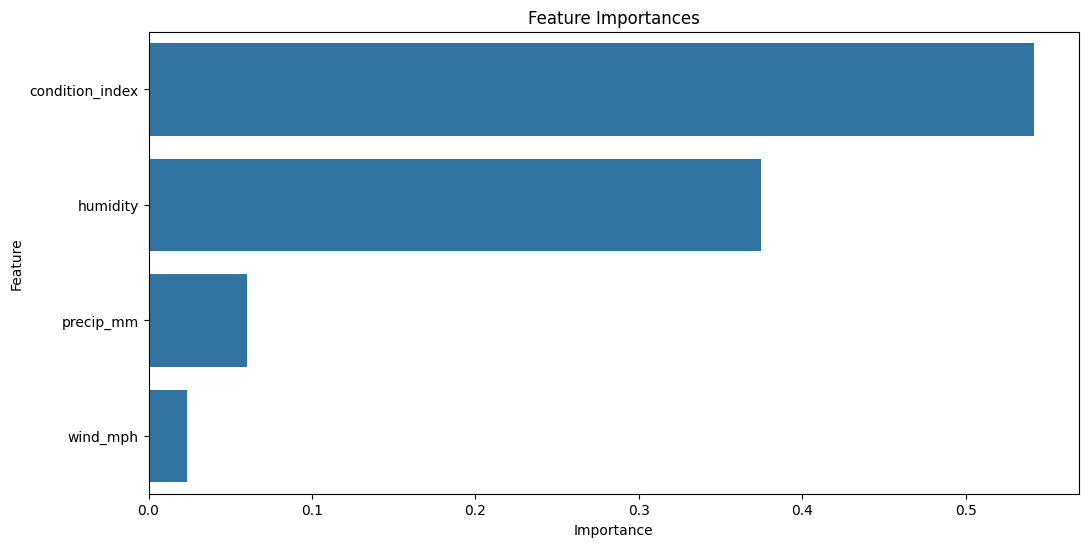

In [10]:
# Lấy độ quan trọng của đặc trưng
feature_importances = rf_model.featureImportances.toArray()

# Tạo DataFrame Pandas để hiển thị
feature_importance_df = pd.DataFrame({"Feature": feature_columns, "Importance": feature_importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)

# Hiển thị biểu đồ
plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
plt.title("Feature Importances")
plt.show()

In [11]:
# Chọn 4 đặc trưng quan trọng nhất
selected_features = feature_importance_df["Feature"].head(4).tolist()
print("Selected Features:", selected_features)

# Tạo DataFrame mới với đặc trưng được chọn
final_data = assembled_data.select("datetime", col("label").alias("temperature"), *["features"])
final_data.show(5)

Selected Features: ['condition_index', 'humidity', 'precip_mm', 'wind_mph']
+-------------------+-----------+-------------------+
|           datetime|temperature|           features|
+-------------------+-----------+-------------------+
|2024-10-18 05:00:00|       25.0| [3.1,89.0,0.0,1.0]|
|2024-10-18 06:00:00|       24.9| [3.4,90.0,0.0,1.0]|
|2024-10-18 07:00:00|       25.9| [3.4,85.0,0.0,1.0]|
|2024-10-18 08:00:00|       27.5| [4.3,77.0,0.2,4.0]|
|2024-10-18 09:00:00|       29.2|[4.9,69.0,0.06,0.0]|
+-------------------+-----------+-------------------+
only showing top 5 rows



In [12]:
# Sắp xếp dữ liệu theo thời gian
data = final_data.orderBy("datetime")
data.show(5)


+-------------------+-----------+------------------+
|           datetime|temperature|          features|
+-------------------+-----------+------------------+
|2024-01-01 00:00:00|       20.7|[5.8,82.0,0.0,1.0]|
|2024-01-01 01:00:00|       20.4|[6.0,84.0,0.0,6.0]|
|2024-01-01 02:00:00|       20.0|[4.9,85.0,0.0,6.0]|
|2024-01-01 03:00:00|       19.8|[4.5,86.0,0.0,2.0]|
|2024-01-01 04:00:00|       19.6|[4.7,87.0,0.0,2.0]|
+-------------------+-----------+------------------+
only showing top 5 rows



In [13]:
# Chia dữ liệu dựa trên thời gian
training_data = data.filter(col("datetime") < "2024-10-30 12:00:00")
testing_data = data.filter(col("datetime") >= "2024-10-30 12:00:00")

# Hiển thị tập train và test
training_data.show(5)
testing_data.show(5)


+-------------------+-----------+------------------+
|           datetime|temperature|          features|
+-------------------+-----------+------------------+
|2024-01-01 00:00:00|       20.7|[5.8,82.0,0.0,1.0]|
|2024-01-01 01:00:00|       20.4|[6.0,84.0,0.0,6.0]|
|2024-01-01 02:00:00|       20.0|[4.9,85.0,0.0,6.0]|
|2024-01-01 03:00:00|       19.8|[4.5,86.0,0.0,2.0]|
|2024-01-01 04:00:00|       19.6|[4.7,87.0,0.0,2.0]|
+-------------------+-----------+------------------+
only showing top 5 rows

+-------------------+-----------+------------------+
|           datetime|temperature|          features|
+-------------------+-----------+------------------+
|2024-10-30 12:00:00|       27.0|[5.1,55.0,0.0,1.0]|
|2024-10-30 13:00:00|       27.6|[6.5,54.0,0.0,1.0]|
|2024-10-30 14:00:00|       27.9|[6.7,52.0,0.0,1.0]|
|2024-10-30 15:00:00|       27.7|[6.0,52.0,0.0,1.0]|
|2024-10-30 16:00:00|       27.3|[4.9,53.0,0.0,1.0]|
+-------------------+-----------+------------------+
only showing top 5 ro

In [14]:
# Chuẩn bị dữ liệu cho dự báo
X_train = training_data.select("datetime")
y_train = training_data.select("temperature")

X_test = testing_data.select("datetime")
y_test = testing_data.select("temperature")
y_test.show(5)

+-----------+
|temperature|
+-----------+
|       27.0|
|       27.6|
|       27.9|
|       27.7|
|       27.3|
+-----------+
only showing top 5 rows



In [15]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [16]:
# import matplotlib.pyplot as plt

# # Chỉ lấy một số lượng nhỏ dữ liệu để vẽ đồ thị (ví dụ: 1000 mẫu)
# num_samples = 100000

# # Thu thập dữ liệu nhỏ hơn để tránh tràn bộ nhớ
# training_data_collected = training_data.select('datetime', 'temperature').limit(num_samples).toPandas()
# testing_data_collected = testing_data.select('datetime', 'temperature').limit(num_samples).toPandas()

# # Vẽ biểu đồ
# plt.figure(figsize=(12, 4))
# plt.plot(training_data_collected['datetime'], training_data_collected['temperature'], color='red', label='Training Data')
# plt.plot(testing_data_collected['datetime'], testing_data_collected['temperature'], color='blue', label='Testing Data')
# plt.xlabel('Time')
# plt.ylabel('Temperature')
# plt.title('Evolution of Temperature Over Time')
# plt.legend()
# plt.show()


In [17]:
# plt.figure(figsize=(12, 4))
# plt.plot(training_data.select('datetime').rdd.flatMap(lambda x: x).collect(), training_data.select('temperature').rdd.flatMap(lambda x: x).collect(), color='red', label='Training Data')
# plt.plot(testing_data.select('datetime').rdd.flatMap(lambda x: x).collect(), testing_data.select('temperature').rdd.flatMap(lambda x: x).collect(), color='blue', label='Testing Data')
# plt.xlabel('Time')
# plt.ylabel('Temperature_2m')
# plt.title('Evolution of Temperature_2m Over Time')
# plt.legend()
# plt.show()

In [18]:
# num = 2000
# plt.figure(figsize=(12, 4))
# plt.plot(training_data.select('datetime').rdd.flatMap(lambda x: x).collect()[-num:], training_data.select('temperature').rdd.flatMap(lambda x: x).collect()[-num:], color='red', label='Training Data')
# plt.plot(testing_data.select('datetime').rdd.flatMap(lambda x: x).collect()[:num], testing_data.select('temperature').rdd.flatMap(lambda x: x).collect()[:num], color='blue', label='Testing Data')
# plt.xlabel('Time')
# plt.ylabel('Temperature_2m')
# plt.title('Evolution of Temperature_2m Over Time')
# plt.legend()
# plt.show()

In [19]:
X_test.printSchema()


root
 |-- datetime: timestamp (nullable = true)



In [20]:
X_test.show()

+-------------------+
|           datetime|
+-------------------+
|2024-10-30 12:00:00|
|2024-10-30 13:00:00|
|2024-10-30 14:00:00|
|2024-10-30 15:00:00|
|2024-10-30 16:00:00|
|2024-10-30 17:00:00|
|2024-10-30 18:00:00|
|2024-10-30 19:00:00|
|2024-10-30 20:00:00|
|2024-10-30 21:00:00|
|2024-10-30 22:00:00|
|2024-10-30 23:00:00|
|2024-10-31 00:00:00|
|2024-10-31 01:00:00|
|2024-10-31 02:00:00|
|2024-10-31 03:00:00|
|2024-10-31 04:00:00|
|2024-10-31 05:00:00|
|2024-10-31 06:00:00|
|2024-10-31 07:00:00|
+-------------------+
only showing top 20 rows



In [21]:
training_data_collected=training_data.select('datetime', 'temperature')
testing_data_collected=testing_data.select('datetime', 'temperature')

In [22]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear,to_timestamp
#training_data_collected = training_data_collected.withColumn('datetime', to_timestamp('datetime'))
# Create new columns based on 'time'
testing_data_collected = (testing_data_collected
    .withColumn('hour', hour('datetime'))
    .withColumn('week', weekofyear('datetime'))
    .withColumn('month', month('datetime'))
    .withColumn('quarter', quarter('datetime'))
    .withColumn('day_of_week', dayofweek('datetime'))
    .withColumn('day_of_month', dayofmonth('datetime'))
    .withColumn('day_of_year', dayofyear('datetime'))
)

# Create new columns based on 'time'
training_data_collected= (training_data_collected
    .withColumn('hour', hour('datetime'))
    .withColumn('week', weekofyear('datetime'))
    .withColumn('month', month('datetime'))
    .withColumn('quarter', quarter('datetime'))
    .withColumn('day_of_week', dayofweek('datetime'))
    .withColumn('day_of_month', dayofmonth('datetime'))
    .withColumn('day_of_year', dayofyear('datetime'))
)
testing_data_collected.show(2000)

+-------------------+-----------+----+----+-----+-------+-----------+------------+-----------+
|           datetime|temperature|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+-----------+----+----+-----+-------+-----------+------------+-----------+
|2024-10-30 12:00:00|       27.0|  12|  44|   10|      4|          4|          30|        304|
|2024-10-30 13:00:00|       27.6|  13|  44|   10|      4|          4|          30|        304|
|2024-10-30 14:00:00|       27.9|  14|  44|   10|      4|          4|          30|        304|
|2024-10-30 15:00:00|       27.7|  15|  44|   10|      4|          4|          30|        304|
|2024-10-30 16:00:00|       27.3|  16|  44|   10|      4|          4|          30|        304|
|2024-10-30 17:00:00|       26.2|  17|  44|   10|      4|          4|          30|        304|
|2024-10-30 18:00:00|       25.3|  18|  44|   10|      4|          4|          30|        304|
|2024-10-30 19:00:00|       24.9|  19|  44|   10| 

In [23]:
# fig, ax = plt.subplots(figsize=(10, 4))
# sns.boxplot( x=training_data_collected.select('hour').rdd.flatMap(lambda x: x).collect(), y=training_data_collected.select('temperature').rdd.flatMap(lambda x: x).collect())
# ax.set_title('MW by Hour')
# plt.show()

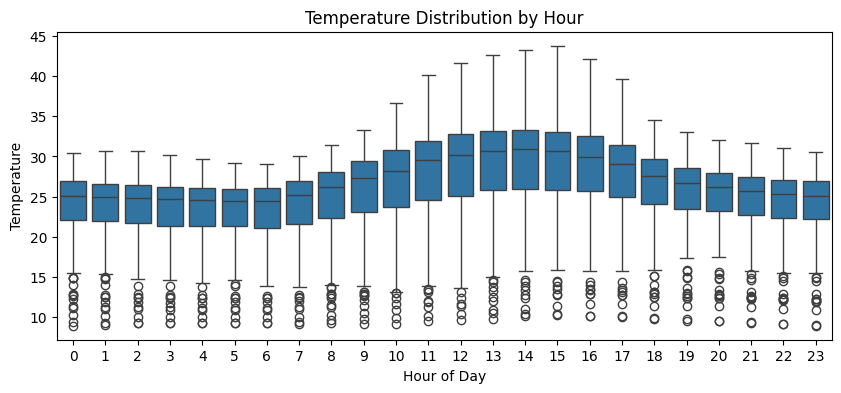

In [24]:
# Chuyển đổi dữ liệu từ Spark sang Pandas
training_data_pandas = training_data_collected.limit(10000).toPandas()

# Đảm bảo cột 'hour' tồn tại
training_data_pandas['hour'] = training_data_pandas['datetime'].dt.hour

# Vẽ biểu đồ boxplot với Seaborn
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(x=training_data_pandas['hour'], y=training_data_pandas['temperature'], ax=ax)
ax.set_title('Temperature Distribution by Hour')
ax.set_xlabel('Hour of Day')
ax.set_ylabel('Temperature')
plt.show()

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear,to_timestamp
#training_data_collected = training_data_collected.withColumn('datetime', to_timestamp('datetime'))
# Create new columns based on 'time'
testing_data_collected = (testing_data_collected
    .withColumn('hour', hour('datetime'))
    .withColumn('week', weekofyear('datetime'))
    .withColumn('month', month('datetime'))
    .withColumn('quarter', quarter('datetime'))
    .withColumn('day_of_week', dayofweek('datetime'))
    .withColumn('day_of_month', dayofmonth('datetime'))
    .withColumn('day_of_year', dayofyear('datetime'))
)

# Create new columns based on 'time'
training_data_collected= (training_data_collected
    .withColumn('hour', hour('datetime'))
    .withColumn('week', weekofyear('datetime'))
    .withColumn('month', month('datetime'))
    .withColumn('quarter', quarter('datetime'))
    .withColumn('day_of_week', dayofweek('datetime'))
    .withColumn('day_of_month', dayofmonth('datetime'))
    .withColumn('day_of_year', dayofyear('datetime'))
)
testing_data_collected.show(2000)

+-------------------+-----------+----+----+-----+-------+-----------+------------+-----------+
|           datetime|temperature|hour|week|month|quarter|day_of_week|day_of_month|day_of_year|
+-------------------+-----------+----+----+-----+-------+-----------+------------+-----------+
|2024-10-30 12:00:00|       27.0|  12|  44|   10|      4|          4|          30|        304|
|2024-10-30 13:00:00|       27.6|  13|  44|   10|      4|          4|          30|        304|
|2024-10-30 14:00:00|       27.9|  14|  44|   10|      4|          4|          30|        304|
|2024-10-30 15:00:00|       27.7|  15|  44|   10|      4|          4|          30|        304|
|2024-10-30 16:00:00|       27.3|  16|  44|   10|      4|          4|          30|        304|
|2024-10-30 17:00:00|       26.2|  17|  44|   10|      4|          4|          30|        304|
|2024-10-30 18:00:00|       25.3|  18|  44|   10|      4|          4|          30|        304|
|2024-10-30 19:00:00|       24.9|  19|  44|   10| 

In [ ]:
# # Định nghĩa các cột đặc trưng
# feature_columns = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']

# # Khởi tạo VectorAssembler
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vector")

# # Vector hóa dữ liệu training và testing
# training_vectorized = assembler.transform(training_data_collected).select("features_vector", "temperature")
# testing_vectorized = assembler.transform(testing_data_collected).select("features_vector", "temperature")

# # Chuyển đổi training data
# train_features = np.array(training_vectorized.select("features_vector").rdd.map(lambda x: x[0].toArray()).collect())
# train_labels = np.array(training_vectorized.select("temperature").rdd.map(lambda x: x[0]).collect())

# # Chuyển đổi testing data
# test_features = np.array(testing_vectorized.select("features_vector").rdd.map(lambda x: x[0].toArray()).collect())
# test_labels = np.array(testing_vectorized.select("temperature").rdd.map(lambda x: x[0]).collect())

# # Định hình lại dữ liệu cho LSTM
# train_features = train_features.reshape((train_features.shape[0], 1, train_features.shape[1]))
# train_labels = train_labels.reshape((-1, 1))
# test_features = test_features.reshape((test_features.shape[0], 1, test_features.shape[1]))
# test_labels = test_labels.reshape((-1, 1))

# # Chuyển đổi thành Tensor
# train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
# train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)
# test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
# test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

# # Tạo DataLoader
# batch_size = 32
# train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [27]:
feature_columns = ['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month', 'day_of_year']

# Khởi tạo VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vector")

In [28]:
# Vector hóa các cột đặc trưng
testing_vectorized = assembler.transform(testing_data_collected).select("features_vector", "temperature")

# Chuyển đổi DataFrame thành NumPy arrays
test_features = np.array(testing_vectorized.select("features_vector").rdd.map(lambda x: x[0]).collect())
test_labels = np.array(testing_vectorized.select("temperature").rdd.map(lambda x: x[0]).collect())

# Định hình lại cho LSTM
test_features = test_features.reshape((test_features.shape[0], 1, test_features.shape[1]))
test_labels = test_labels.reshape((-1, 1))


In [42]:
train_features.shape

(7284, 1, 7)

In [29]:
# Vector hóa các cột đặc trưng trong training_data_collected
training_vectorized = assembler.transform(training_data_collected).select("features_vector", "temperature")

# Chuyển đổi training DataFrame thành NumPy arrays
train_features = np.array(training_vectorized.select("features_vector").rdd.map(lambda x: x[0]).collect())
train_labels = np.array(training_vectorized.select("temperature").rdd.map(lambda x: x[0]).collect())

# Định hình lại cho LSTM
train_features = train_features.reshape((train_features.shape[0], 1, train_features.shape[1]))
train_labels = train_labels.reshape((-1, 1))

In [30]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Chuyển đổi training data
train_features_tensor = torch.tensor(train_features, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.float32)

# Chuyển đổi testing data
test_features_tensor = torch.tensor(test_features, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.float32)

# Tạo DataLoader
batch_size = 32
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [54]:
print(train_features.shape)  # Kỳ vọng: (num_samples, num_features)
print(train_labels.shape)    # Kỳ vọng: (num_samples,)


(7284, 1, 7)
(7284, 1)


In [55]:
print(train_sequences.shape)  # Kỳ vọng: (num_samples, sequence_length, num_features)
print(train_targets.shape)    # Kỳ vọng: (num_samples,)


(7264, 20, 1, 7)
(7264, 1)


In [56]:
print(train_features_tensor.shape)  # Kỳ vọng: (num_samples, sequence_length, num_features)
print(train_labels_tensor.shape)    # Kỳ vọng: (num_samples,)


torch.Size([7264, 20, 1, 7])
torch.Size([7264, 1])


In [43]:
def create_sequences(features, labels, sequence_length):
    """
    Tạo các chuỗi liên tiếp từ dữ liệu đặc trưng (features) và nhãn (labels).
    
    Args:
        features (ndarray): Dữ liệu đặc trưng.
        labels (ndarray): Dữ liệu nhãn.
        sequence_length (int): Độ dài chuỗi.
    
    Returns:
        tuple: Các chuỗi đặc trưng và nhãn tương ứng.
    """
    sequences = []
    targets = []
    for i in range(len(features) - sequence_length):
        seq = features[i:i + sequence_length]
        target = labels[i + sequence_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Chuẩn bị dữ liệu
sequence_length = 20

# Chuỗi cho tập huấn luyện
train_sequences, train_targets = create_sequences(train_features, train_labels, sequence_length)

# Chuỗi cho tập kiểm tra
test_sequences, test_targets = create_sequences(test_features, test_labels, sequence_length)

# Chuyển đổi thành Tensor
train_features_tensor = torch.tensor(train_sequences, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_targets, dtype=torch.float32)
test_features_tensor = torch.tensor(test_sequences, dtype=torch.float32)
test_labels_tensor = torch.tensor(test_targets, dtype=torch.float32)

# Tạo DataLoader
batch_size = 32
train_dataset = TensorDataset(train_features_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(test_features_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [57]:
# Loại bỏ chiều thừa ở giữa
train_features_tensor = train_features_tensor.squeeze(2)  # (7264, 20, 7)
test_features_tensor = test_features_tensor.squeeze(2)    # (num_test_samples, 20, 7)

In [58]:
print(train_features_tensor.shape)  # Kỳ vọng: (7264, 20, 7)
print(train_labels_tensor.shape)    # Kỳ vọng: (7264,)


torch.Size([7264, 20, 7])
torch.Size([7264, 1])


In [59]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # LSTM layer
        lstm_out, _ = self.lstm(x)
        # Lấy đầu ra tại bước thời gian cuối cùng
        output = lstm_out[:, -1, :]
        # Dự đoán giá trị
        output = self.fc(output)
        return output

# Tham số mô hình
input_dim = len(feature_columns)  # Số lượng đặc trưng
hidden_dim = 50  # Số chiều ẩn
output_dim = 1  # Dự đoán một giá trị đầu ra
num_layers = 2  # Số lớp LSTM

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)


In [60]:
# Loss function và optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Huấn luyện
epochs = 20
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        if inputs.dim() == 4:
            inputs = inputs.squeeze(2)  # Loại bỏ chiều channels
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/20, Loss: 324.5018
Epoch 2/20, Loss: 83.5961
Epoch 3/20, Loss: 34.3848
Epoch 4/20, Loss: 27.5577
Epoch 5/20, Loss: 20.0855
Epoch 6/20, Loss: 13.4940
Epoch 7/20, Loss: 12.4330
Epoch 8/20, Loss: 11.3304
Epoch 9/20, Loss: 10.3788
Epoch 10/20, Loss: 7.6943
Epoch 11/20, Loss: 6.5135
Epoch 12/20, Loss: 6.0085
Epoch 13/20, Loss: 5.7152
Epoch 14/20, Loss: 5.7777
Epoch 15/20, Loss: 5.4691
Epoch 16/20, Loss: 5.3282
Epoch 17/20, Loss: 5.0736
Epoch 18/20, Loss: 4.8857
Epoch 19/20, Loss: 4.8988
Epoch 20/20, Loss: 4.6981


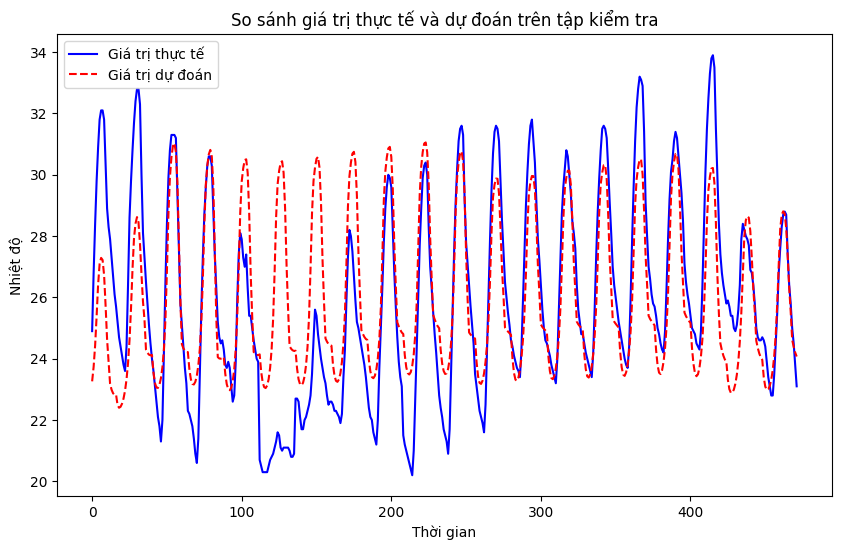

In [66]:
# Đưa mô hình vào chế độ đánh giá
model.eval()

# Dự đoán trên tập kiểm tra
test_predictions = []
test_labels_list = []

with torch.no_grad():
    for inputs, labels in test_loader:
        if inputs.dim() == 4:
            inputs = inputs.squeeze(2)  # Loại bỏ chiều channels
        outputs = model(inputs)
        test_predictions.append(outputs.numpy())
        test_labels_list.append(labels.numpy())

test_predictions = np.concatenate(test_predictions)
test_labels_list = np.concatenate(test_labels_list)

# Hiển thị biểu đồ
plt.figure(figsize=(10, 6))
plt.plot(test_labels_list, label='Giá trị thực tế', color='blue')
plt.plot(test_predictions, label='Giá trị dự đoán', color='red', linestyle='dashed')
plt.title('So sánh giá trị thực tế và dự đoán trên tập kiểm tra')
plt.xlabel('Thời gian')
plt.ylabel('Nhiệt độ')
plt.legend()
plt.show()


In [67]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Tính MSE và RMSE cho tập huấn luyện và kiểm tra
train_mse = mean_squared_error(train_labels_list, train_predictions)
test_mse = mean_squared_error(test_labels_list, test_predictions)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

# Tính MAE cho tập huấn luyện và kiểm tra
train_mae = mean_absolute_error(train_labels_list, train_predictions)
test_mae = mean_absolute_error(test_labels_list, test_predictions)

# In kết quả
print(f'MSE (Train): {train_mse}')
print(f'RMSE (Train): {train_rmse}')
print(f'MAE (Train): {train_mae}')

print(f'MSE (Test): {test_mse}')
print(f'RMSE (Test): {test_rmse}')
print(f'MAE (Test): {test_mae}')


MSE (Train): 27.011953353881836
RMSE (Train): 5.197302341461182
MAE (Train): 3.923003911972046
MSE (Test): 4.9886088371276855
RMSE (Test): 2.2335193157196045
MAE (Test): 1.638264536857605


In [ ]:
stopppp

NameError: name 'stopppp' is not defined

In [ ]:
X_train_pd = X_train.withColumn("datetime", col("datetime").cast("string")).toPandas()
y_train_pd = y_train.toPandas()
X_test_pd = X_test.withColumn("datetime", col("datetime").cast("string")).toPandas()
y_test_pd = y_test.toPandas()

In [ ]:
# Combine X_train and y_train into a single Pandas DataFrame
train_data = pd.concat([X_train_pd, y_train_pd], axis=1)

# Combine X_test and y_test into a single Pandas DataFrame
test_data = pd.concat([X_test_pd, y_test_pd], axis=1)

In [ ]:
from pyspark.ml.feature import MinMaxScaler, VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col
# Normalize the data
feature_columns = [ 'hour', 'week', 'month', 'quarter', 'day_of_week',
       'day_of_month', 'day_of_year']

scaler = MinMaxScaler()
training_data_collected[feature_columns] = scaler.fit_transform(training_data_collected[feature_columns])
testing_data_collected[feature_columns] = scaler.transform(testing_data_collected[feature_columns])
spark.createDataFrame(train_data).show()

ValueError: setting an array element with a sequence.

In [ ]:
import numpy as np
from pyspark.ml.feature import VectorAssembler
feature_columns = [ 'hour', 'week', 'month', 'quarter', 'day_of_week',
       'day_of_month', 'day_of_year']
# Chuẩn bị dữ liệu để sử dụng với LSTM
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_vector")
training_data_vectorized = assembler.transform(training_data_collected).select("features_vector", "temperature")

# Chuyển dữ liệu Spark thành NumPy arrays
train_features = np.array(training_data_vectorized.select("features_vector").rdd.map(lambda x: x[0]).collect())
train_labels = np.array(training_data_vectorized.select("temperature").rdd.map(lambda x: x[0]).collect())

# Reshape dữ liệu cho LSTM [samples, time_steps, features]
time_steps = 1  # Một bước thời gian
train_features = train_features.reshape((train_features.shape[0], time_steps, train_features.shape[1]))
train_labels = train_labels.reshape((-1, 1))  # Đảm bảo nhãn là một vector cột


In [ ]:
# Create sequences for LSTM
def create_sequences(data, sequence_length=24):
    sequences = []
    for i in range(len(data) - sequence_length + 1):
        sequence = data.iloc[i:i+sequence_length]
        sequences.append(sequence.values)
    return np.array(sequences)

# Create sequences for training and testing
sequence_length = 24  # You can adjust this based on your preference
X_train_seq = create_sequences(train_data[feature_columns])
y_train_seq = train_data['temperature_2m'].values[sequence_length-1:]

X_test_seq = create_sequences(test_data[feature_columns])
y_test_seq = test_data['temperature_2m'].values[sequence_length-1:]
X_train_seq

KeyError: "None of [Index(['hour', 'week', 'month', 'quarter', 'day_of_week', 'day_of_month',\n       'day_of_year'],\n      dtype='object')] are in the [columns]"

In [ ]:
# Build the deep LSTM model with 10 hidden layers
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))
for _ in range(8):  # Add 8 more LSTM layers
    model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu'))  # Last LSTM layer without return_sequences
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

I0000 00:00:1731712191.377312   23602 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731712191.491055   23602 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731712191.491282   23602 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731712191.493323   23602 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 50)         │        11,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 24, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,451 (755.67 KB)

 Trainable params: 193,451 (755.67 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(X_train_seq, y_train_seq, epochs=15, batch_size=32, validation_split=0.1, verbose=1)


Epoch 1/15


I0000 00:00:1731712197.838290   29658 service.cc:146] XLA service 0xaa73f70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731712197.838313   29658 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Ti Laptop GPU, Compute Capability 8.6
2024-11-16 00:09:58.027619: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-16 00:09:59.213748: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-11-16 00:09:59.780510: W external/local_xla/xla/stream_executor/gpu/redzone_allocator_kernel_cuda.cc:136] NOT_FOUND: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/yasminehabchi/anaconda3/bin/ptxas, /opt/apache-maven-3.6.3/bin/ptxas, /home/yasminehabchi/.local/bin/ptxas, /home/yasminehabchi/Downloads/apache-tomcat

NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/yasminehabchi/anaconda3/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/yasminehabchi/anaconda3/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 18, in <module>

  File "/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 739, in start

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/home/yasminehabchi/anaconda3/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/yasminehabchi/anaconda3/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once

  File "/home/yasminehabchi/anaconda3/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in process_one

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 362, in execute_request

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 778, in execute_request

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 449, in do_execute

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/home/yasminehabchi/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_23602/3299210463.py", line 2, in <module>

  File "/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/home/yasminehabchi/anaconda3/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/yasminehabchi/anaconda3/bin/ptxas, /opt/apache-maven-3.6.3/bin/ptxas, /home/yasminehabchi/.local/bin/ptxas, /home/yasminehabchi/Downloads/apache-tomcat-10.1.9/bin/ptxas, /usr/lib/jvm/jdk-21.0.4-oracle-x64/bin/ptxas, /home/yasminehabchi/anaconda3/bin/ptxas, /home/yasminehabchi/anaconda3/condabin/ptxas, /opt/maven/bin/ptxas, /opt/apache-maven-3.6.3/bin/ptxas, /home/yasminehabchi/.local/bin/ptxas, /opt/maven/bin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /snap/bin/ptxas, /snap/bin/ptxas, /home/yasminehabchi/Downloads/apache-activemq-5.18.1/bin/ptxas, /usr/local/cuda-12.3/bin/ptxas, /usr/local/cuda/bin/ptxas, /home/yasminehabchi/anaconda3/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/yasminehabchi/anaconda3/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_iterator_15875]

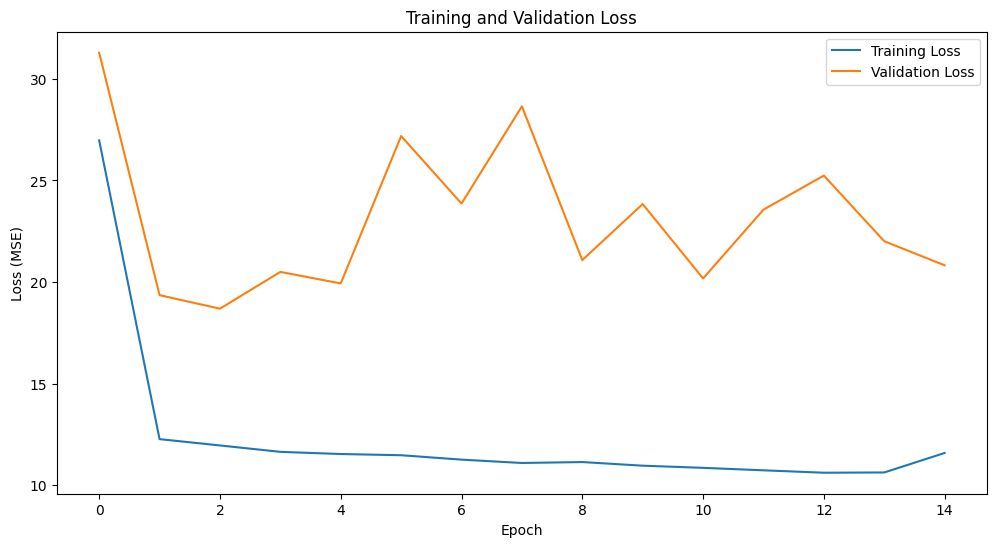

In [ ]:
# Plot the loss over epochs
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [ ]:
# Reshape predictions for compatibility with evaluation functions
y_pred = y_pred.flatten()

# Calculate metrics
mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = mean_squared_error(y_test_seq, y_pred, squared=False)
r2 = r2_score(y_test_seq, y_pred)

print("Mean Absolute Error: {}".format(mae))
print("Mean Squared Error: {}".format(mse))
print("Root Mean Squared Error: {}".format(rmse))
print("R-squared: {}".format(r2))

Mean Absolute Error: 2.4098195604946833
Mean Squared Error: 11.65433335971432
Root Mean Squared Error: 3.4138443666509346
R-squared: 0.6490038712783298


1370/1370 [==============================] - 79s 58ms/step
RMSE: 3.4138443666509346


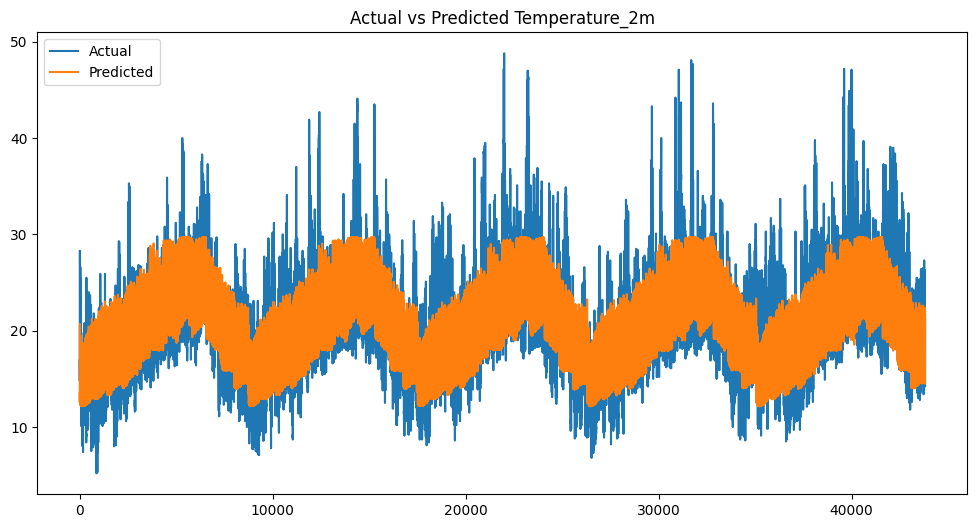

In [ ]:
# Make predictions on the test data
y_pred = model.predict(X_test_seq)

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(y_test_seq, y_pred))
print("RMSE:", rmse)

# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Temperature_2m')
plt.legend()
plt.show()

In [ ]:
import os
from tensorflow.keras.models import save_model, load_model

# ... (previous code)

# Save the model to the 'models' folder
model_save_path = 'models/model_lstm'
os.makedirs('models', exist_ok=True)
save_model(model, model_save_path)



INFO:tensorflow:Assets written to: models/model_lstm/assets


INFO:tensorflow:Assets written to: models/model_lstm/assets


In [ ]:

# Load the model from the 'models' folder
loaded_model = load_model(model_save_path)


1370/1370 [==============================] - 76s 54ms/step
RMSE (loaded model): 3.4138443666509346


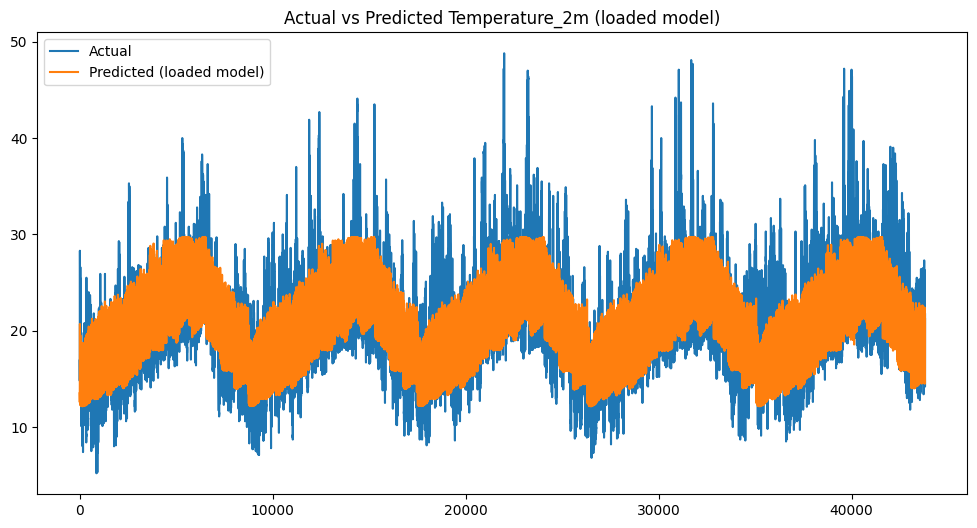

In [ ]:

# Make predictions on the test data using the loaded model
y_pred_loaded = loaded_model.predict(X_test_seq)

# Calculate RMSE (Root Mean Squared Error) using the loaded model
rmse_loaded = np.sqrt(mean_squared_error(y_test_seq, y_pred_loaded))
print("RMSE (loaded model):", rmse_loaded)

# Plot the actual vs predicted values using the loaded model
plt.figure(figsize=(12, 6))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_loaded, label='Predicted (loaded model)')
plt.title('Actual vs Predicted Temperature_2m (loaded model)')
plt.legend()
plt.show()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, hour, weekofyear, month, quarter, dayofweek, dayofmonth, dayofyear



X_test = (X_test
    .withColumn('hour', hour('time'))
    .withColumn('week', weekofyear('time'))
    .withColumn('month', month('time'))
    .withColumn('quarter', quarter('time'))
    .withColumn('day_of_week', dayofweek('time'))
    .withColumn('day_of_month', dayofmonth('time'))
    .withColumn('day_of_year', dayofyear('time'))
)


In [ ]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setAppName('Elephas_App').setMaster('local[8]')
spark = SparkContext(conf=conf)
file_path = 'data/weather_data.csv'
sep = '|'
weather_data = spark.read.option("sep", sep).csv(file_path, header=True, inferSchema=True)


ConnectionRefusedError: [Errno 111] Connection refused